In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import bisect

import warnings

warnings.filterwarnings("ignore")

## Libraries and Constants


In [2]:
TENOR_MAPPING = {"m": 1 / 12, "y": 1}


def interpolate_discount_factor_between_tenor(
    prev_discount_factor: float,
    next_discount_factor: float,
    prev_tenor: float,
    next_tenor: float,
    curr_tenor: float,
) -> float:
    """This function interpolates the discount factor of a tenor
    between two different discount factors

    Args:
        prev_discount_factor (float): previous discount factor
        next_discount_factor (float): next discount factor
        prev_tenor (float): previous tenor
        next_tenor (float): next tenor
        curr_tenor (float): current tenor

    Returns:
        float: interpolated discount factor
    """
    return prev_discount_factor + (next_discount_factor - prev_discount_factor) * (
        curr_tenor - prev_tenor
    ) / (next_tenor - prev_tenor)

## Input Data


In [3]:
file_directory = "../data/IR data.xlsx"

## 1. OIS Curve Fitting


In [4]:
class OISBootstrapping:
    """
    This is a class to bootstrap OIS curves in order to generate
    its respective OIS Discount Factor
    """

    def __init__(self, filename: str, fixed_leg_period: float = 1):
        """
        Initialization of OISBootstrapping class

        Args:
            filename (str): path of the OIS data
            fixed_leg_period (float, optional): the period of fixed leg payment. Defaults to 1.
        """
        self.df_ois = self.read_file(filename)
        self.day_count_convention = {"accrual_period": 30, "annual_days": 360}
        self.floating_leg_period = 1 / 360
        self.fixed_leg_period = fixed_leg_period

        self.format_data()
        self.bootstrap_below_fixed_leg_period()
        self.bootstrap_above_fixed_leg_period()
        self.plot_discount_curve()

    def read_file(self, filename: str) -> pd.DataFrame:
        """This function reads text file and returns the data as a DataFrame

        Args:
            filename (str): path of the OIS data

        Returns:
            pd.DataFrame: OIS data
        """
        df_ois = pd.read_excel(filename, sheet_name="OIS")
        return df_ois

    def format_data(self):
        """This function formats OIS data"""
        df_ois_formatted = self.df_ois.copy().iloc[:, :3]
        df_ois_formatted["Tenor"] = (
            df_ois_formatted["Tenor"]
            .str.extract(r"(\d+)([my])")
            .apply(lambda x: int(x[0]) * TENOR_MAPPING[x[1]], axis=1)
        )
        df_ois_formatted["Tenor Delta"] = df_ois_formatted["Tenor"] - df_ois_formatted[
            "Tenor"
        ].shift().fillna(0)
        df_ois_formatted["Discount Factor"] = 0.0
        df_ois_formatted["Overnight Rate"] = 0.0
        df_ois_formatted["PV Float"] = 0.0
        df_ois_formatted["PV Fix"] = 0.0

        self.df_ois = df_ois_formatted.copy()

    def get_compounded_return_func(self, year_num: float) -> Callable[[float], float]:
        """This function returns a function that calculates the daily compounded return
        based on a certain number of years
        given an overnight rate

        Args:
            year_num (float): number of years

        Returns:
            Callable[[float], float]: a function that
                takes in the overnight rate and computes the compounded return
        """
        return lambda overnight_rate: (
            1 + overnight_rate / self.day_count_convention["annual_days"]
        ) ** (year_num * self.day_count_convention["annual_days"])

    def get_current_discount_factor_func(
        self, prev_discount_factor: float, year_diff: float
    ) -> Callable[[float], float]:
        """This function returns a function that calculates the current discount factor
        based on the previous discount factor
        and the year difference between the previous and the current discount factor
        given an overnight rate

        Args:
            prev_discount_factor (float): previous discount factor
            year_num (float): number of years

        Returns:
            Callable[[float], float]: a function
        """
        return (
            lambda overnight_rate: prev_discount_factor
            * 1
            / self.get_compounded_return_func(year_diff)(overnight_rate)
        )

    def bootstrap_below_fixed_leg_period(self):
        """This function bootstraps the OIS curve in order to get the discount factors
        for the tenors below the fixed leg period
        """
        df_ois_below_fixed_leg_period = self.df_ois[
            self.df_ois["Tenor"] <= self.fixed_leg_period
        ]
        for index, ois_row in df_ois_below_fixed_leg_period.iterrows():
            tenor, rate, tenor_delta = (
                ois_row["Tenor"],
                ois_row["Rate"],
                ois_row["Tenor Delta"],
            )
            prev_discount_factor = (
                1 if index == 0 else self.df_ois.loc[index - 1]["Discount Factor"]
            )
            current_discount_factor_function = self.get_current_discount_factor_func(
                prev_discount_factor, tenor_delta
            )

            # Fixed Leg
            def present_value_fixed_func(f):
                return current_discount_factor_function(f) * tenor * rate

            # Floating Leg
            prev_ois_data = self.df_ois.loc[: index - 1]
            prev_compounded_returns = np.prod(
                [
                    self.get_compounded_return_func(ois_row["Tenor Delta"])(
                        ois_row["Overnight Rate"]
                    )
                    for _, ois_row in prev_ois_data.iterrows()
                ]
            )

            def present_value_floating_func(f):
                return current_discount_factor_function(f) * (
                    prev_compounded_returns
                    * self.get_compounded_return_func(tenor_delta)(f)
                    - 1
                )

            f = bisect(
                lambda f: (
                    present_value_fixed_func(f) - present_value_floating_func(f)
                ),
                0,
                1,
            )

            self.df_ois.loc[index, "Overnight Rate"] = f
            self.df_ois.loc[index, "Discount Factor"] = (
                current_discount_factor_function(f)
            )
            self.df_ois.loc[index, "PV Float"] = present_value_floating_func(f)
            self.df_ois.loc[index, "PV Fix"] = present_value_fixed_func(f)

    def bootstrap_above_fixed_leg_period(self):
        """This function bootstraps the OIS curve in order to get the discount factors
        for the tenors above the fixed leg period
        """
        df_ois_above_fixed_leg_period = self.df_ois[
            self.df_ois["Tenor"] > self.fixed_leg_period
        ]
        for index, ois_row in df_ois_above_fixed_leg_period.iterrows():
            tenor, rate = (
                ois_row["Tenor"],
                ois_row["Rate"],
            )

            prev_discount_factor, prev_tenor = self.df_ois.loc[
                index - 1, ["Discount Factor", "Tenor"]
            ]

            prev_discount_factor_dict = {}
            for i in np.arange(
                self.fixed_leg_period,
                tenor,
                self.fixed_leg_period,
            ):
                discount_factor = self.df_ois[self.df_ois["Tenor"] == i][
                    "Discount Factor"
                ].values

                if len(discount_factor) == 0:
                    # Discount factor of a certain tenor is not found in the dataframe.
                    # As such, the value needs to be interpolated
                    if i < prev_tenor:
                        ois_row_before_i = self.df_ois[self.df_ois["Tenor"] < i].iloc[
                            -1, :
                        ]
                        ois_row_after_i = self.df_ois[self.df_ois["Tenor"] > i].iloc[
                            0, :
                        ]
                        prev_discount_factor_dict[i] = (
                            interpolate_discount_factor_between_tenor(
                                ois_row_before_i["Discount Factor"],
                                ois_row_after_i["Discount Factor"],
                                ois_row_before_i["Tenor"],
                                ois_row_after_i["Tenor"],
                                i,
                            )
                        )
                    else:
                        prev_discount_factor_dict[i] = (
                            lambda discount_factor, interp_tenor: interpolate_discount_factor_between_tenor(
                                prev_discount_factor,
                                discount_factor,
                                prev_tenor,
                                tenor,
                                interp_tenor,
                            )
                        )

                else:
                    prev_discount_factor_dict[i] = discount_factor[0]

            # Fixed Leg

            def present_value_fixed_func(curr_discount_factor: float):
                known_present_value_fixed = sum(
                    val(curr_discount_factor, key) if callable(val) else val
                    for key, val in prev_discount_factor_dict.items()
                )
                val = (known_present_value_fixed + curr_discount_factor) * rate
                return val

            # Floating Leg
            prev_present_value_floating_cumulative = self.df_ois.loc[
                index - 1, "PV Float"
            ]

            def present_value_floating_func(curr_discount_factor: float):
                val = (
                    prev_present_value_floating_cumulative
                    + prev_discount_factor
                    - curr_discount_factor
                )
                return val

            discount_factor = bisect(
                lambda d: (
                    present_value_fixed_func(d) - present_value_floating_func(d)
                ),
                0,
                10,
            )

            prev_year_discount_factor_item = list(prev_discount_factor_dict.items())[-1]
            prev_year_discount_factor = (
                prev_year_discount_factor_item[1](
                    discount_factor, prev_year_discount_factor_item[0]
                )
                if callable(prev_year_discount_factor_item[1])
                else prev_year_discount_factor_item[1]
            )
            self.df_ois.loc[index, "Overnight Rate"] = 360 * (
                (prev_year_discount_factor / discount_factor) ** (1 / 360) - 1
            )
            self.df_ois.loc[index, "Discount Factor"] = discount_factor
            self.df_ois.loc[index, "PV Float"] = present_value_floating_func(
                discount_factor
            )
            self.df_ois.loc[index, "PV Fix"] = present_value_fixed_func(discount_factor)

    def plot_discount_curve(self):
        """This function plots the boostrapped discount curve of the OIS data"""
        plt.style.use("classic")
        plt.plot(self.df_ois["Tenor"], self.df_ois["Discount Factor"])
        plt.scatter(self.df_ois["Tenor"], self.df_ois["Discount Factor"])
        plt.xlim(self.df_ois["Tenor"].min(), self.df_ois["Tenor"].max())
        plt.ylim(
            self.df_ois["Discount Factor"].min(), self.df_ois["Discount Factor"].max()
        )
        plt.xlabel("Tenor (years)")
        plt.ylabel("OIS Discount Factor")
        plt.title("OIS Discount Factor vs Tenor")
        plt.grid()
        plt.savefig("output/OIS Discount Curve.png")

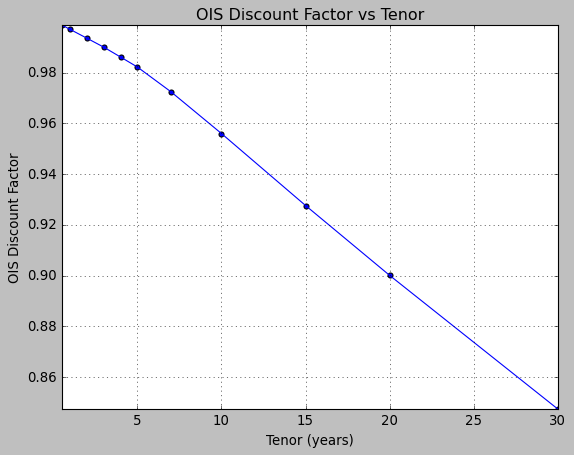

In [5]:
ois_bootstrapping = OISBootstrapping(file_directory)
df_ois = ois_bootstrapping.df_ois

In [6]:
df_ois

,Tenor,Product,Rate,Tenor Delta,Discount Factor,Overnight Rate,PV Float,PV Fix
0,0.5,OIS,0.00250,0.5,0.998752,0.002498,0.001248,0.001248
1,1.0,OIS,0.00300,0.5,0.997009,0.003493,0.002991,0.002991
2,2.0,OIS,0.00325,1.0,0.993531,0.003495,0.006469,0.006469
3,3.0,OIS,0.00335,1.0,0.990015,0.003545,0.009985,0.009985
4,4.0,OIS,0.00350,1.0,0.986117,0.003946,0.013883,0.013883
5,5.0,OIS,0.00360,1.0,0.982184,0.003996,0.017816,0.017816
6,7.0,OIS,0.00400,2.0,0.972406,0.005015,0.027594,0.027594
7,10.0,OIS,0.00450,3.0,0.955977,0.005712,0.044023,0.044023
8,15.0,OIS,0.00500,5.0,0.927611,0.006097,0.072389,0.072389
9,20.0,OIS,0.00525,5.0,0.900076,0.006100,0.099924,0.099924


## 2. LIBOR Bootstrapping


In [7]:
class LIBORBootstrapping:
    def __init__(
        self,
        filename: str,
        df_ois: pd.DataFrame,
        fixed_leg_period: float = 1,
        floating_leg_period: float = 1,
    ):
        self.df_irs = self.read_file(filename)
        self.df_ois = df_ois
        self.day_count_convention = {"accrual_period": 30, "annual_days": 360}
        self.floating_leg_period = floating_leg_period
        self.fixed_leg_period = fixed_leg_period

        self.format_data()
        self.interpolate_ois_data()
        self.bootstrap_libor_product()
        self.bootstrap_irs_product()
        self.df_irs = self.df_irs.dropna()
        self.plot_discount_curve()

    def read_file(self, filename: str) -> pd.DataFrame:
        """This function reads text file and returns the data as a DataFrame

        Args:
            filename (str): path of the IRS data

        Returns:
            pd.DataFrame: IRS data
        """
        df_irs = pd.read_excel(filename, sheet_name="IRS")
        return df_irs

    def format_data(self):
        """This function formats IRS data"""
        df_irs_formatted = self.df_irs.copy().iloc[:, :3]
        df_irs_formatted["Tenor"] = (
            df_irs_formatted["Tenor"]
            .str.extract(r"(\d+)([my])")
            .apply(lambda x: int(x[0]) * TENOR_MAPPING[x[1]], axis=1)
        )
        df_irs_formatted["Tenor Delta"] = df_irs_formatted["Tenor"] - df_irs_formatted[
            "Tenor"
        ].shift().fillna(0)
        df_irs_formatted = df_irs_formatted.set_index("Tenor")
        min_tenor = self.df_ois["Tenor"].min()
        max_tenor = self.df_ois["Tenor"].max()
        delta_tenor = min(self.floating_leg_period, self.fixed_leg_period)
        df_irs_formatted = df_irs_formatted.reindex(
            df_irs_formatted.index.union(np.arange(min_tenor, max_tenor, delta_tenor))
        )
        df_irs_formatted["Discount Factor"] = 0.0
        df_irs_formatted["Forward LIBOR"] = 0.0
        self.df_irs = df_irs_formatted.copy()

    def interpolate_ois_data(self):
        # Interpolate OIS data to match the tenor of the IRS payment frequency
        min_tenor = self.df_ois["Tenor"].min()
        max_tenor = self.df_ois["Tenor"].max()
        delta_tenor = min(self.floating_leg_period, self.fixed_leg_period)
        df_ois_formatted = self.df_ois.copy().set_index("Tenor")
        df_ois_formatted = df_ois_formatted.reindex(
            df_ois_formatted.index.union(np.arange(min_tenor, max_tenor, delta_tenor))
        )
        df_ois_formatted["Product"] = "OIS"
        df_ois_formatted["Discount Factor"] = df_ois_formatted[
            "Discount Factor"
        ].interpolate(method="linear")
        self.df_ois = df_ois_formatted

    def compute_forward_libor(
        self,
        delta_tenor: float,
        previous_discount_factor: float,
        current_discount_factor: float,
    ) -> float:
        return (
            1 / delta_tenor * (previous_discount_factor / current_discount_factor - 1)
        )

    def bootstrap_libor_product(self):
        # Compute Discount Factor
        df_libor_idx = self.df_irs[self.df_irs["Product"] == "LIBOR"].index
        df_libor = self.df_irs.loc[df_libor_idx]
        self.df_irs.loc[df_libor_idx, "Discount Factor"] = 1 / (
            1 + df_libor.index * df_libor["Rate"]
        )

        # Compute the first forward LIBOR
        df_first_libor = self.df_irs.iloc[0]
        self.df_irs.loc[0.5, "Forward LIBOR"] = self.compute_forward_libor(
            df_first_libor["Tenor Delta"], 1, df_first_libor["Discount Factor"]
        )

    def bootstrap_irs_product(self):
        df_irs = self.df_irs[self.df_irs["Product"] == "IRS"]
        prev_index = 0.5
        for index, irs_row in df_irs.iterrows():
            tenor, rate = (
                index,
                irs_row["Rate"],
            )
            prev_tenor, prev_discount_factor = (
                prev_index,
                self.df_irs.loc[prev_index]["Discount Factor"],
            )

            # Fixed Leg
            fixed_leg_terms = np.arange(
                self.fixed_leg_period,
                tenor + self.fixed_leg_period,
                self.fixed_leg_period,
            )
            fixed_leg_discount_factors = self.df_ois.loc[
                fixed_leg_terms, "Discount Factor"
            ]
            fixed_leg_pv = (
                np.sum(fixed_leg_discount_factors) * self.fixed_leg_period * rate
            )

            # Floating leg
            floating_leg_terms = np.arange(
                self.fixed_leg_period,
                tenor + self.fixed_leg_period,
                self.floating_leg_period,
            )

            floating_leg_tenors_of_known_pv = floating_leg_terms[
                floating_leg_terms <= prev_tenor
            ]
            floating_leg_tenors_of_unknown_pv = floating_leg_terms[
                floating_leg_terms > prev_tenor
            ]

            floating_leg_known_libor_forward = self.df_irs.loc[
                floating_leg_tenors_of_known_pv
            ]["Forward LIBOR"].values
            floating_leg_known_ois_discount_factor = self.df_ois.loc[
                floating_leg_tenors_of_known_pv
            ]["Discount Factor"].values
            floating_leg_known_pv = (
                np.sum(
                    floating_leg_known_libor_forward
                    * floating_leg_known_ois_discount_factor
                )
                * self.floating_leg_period
            )

            def floating_leg_unknown_pv(curr_discount_factor: float):
                floating_leg_cashflow = []
                prev_libor_discount_factor = prev_discount_factor
                for term in floating_leg_tenors_of_unknown_pv:
                    ois_discount_factor = self.df_ois.loc[term, "Discount Factor"]
                    libor_discount_factor = interpolate_discount_factor_between_tenor(
                        prev_discount_factor,
                        curr_discount_factor,
                        prev_tenor,
                        tenor,
                        term,
                    )
                    cashflow = (
                        self.floating_leg_period
                        * ois_discount_factor
                        * self.compute_forward_libor(
                            self.floating_leg_period,
                            prev_libor_discount_factor,
                            libor_discount_factor,
                        )
                    )

                    floating_leg_cashflow.append(cashflow)
                    prev_libor_discount_factor = libor_discount_factor

                return sum(floating_leg_cashflow)

            discount_factor = bisect(
                lambda d: (
                    fixed_leg_pv - floating_leg_known_pv - floating_leg_unknown_pv(d)
                ),
                0,
                10,
            )

            # Compute interpolated data
            for term in floating_leg_tenors_of_unknown_pv:
                prev_libor_discount_factor = self.df_irs.loc[
                    term - self.floating_leg_period, "Discount Factor"
                ]
                libor_discount_factor = interpolate_discount_factor_between_tenor(
                    prev_discount_factor,
                    discount_factor,
                    prev_tenor,
                    tenor,
                    term,
                )
                self.df_irs.loc[term, "Discount Factor"] = libor_discount_factor
                self.df_irs.loc[term, "Forward LIBOR"] = self.compute_forward_libor(
                    self.floating_leg_period,
                    prev_libor_discount_factor,
                    libor_discount_factor,
                )

            prev_index = index

    def plot_discount_curve(self):
        """This function plots the boostrapped discount curve of the IRS data"""
        plt.style.use("classic")
        tenor = self.df_irs.index
        plt.plot(tenor, self.df_irs["Discount Factor"])
        plt.scatter(tenor, self.df_irs["Discount Factor"])
        plt.xlim(tenor.min(), tenor.max())
        plt.ylim(
            self.df_irs["Discount Factor"].min(), self.df_irs["Discount Factor"].max()
        )
        plt.xlabel("Tenor (years)")
        plt.ylabel("LIBOR Discount Factor")
        plt.title("LIBOR Discount Factor vs Tenor")
        plt.grid()
        plt.savefig("output/LIBOR Discount Curve.png")

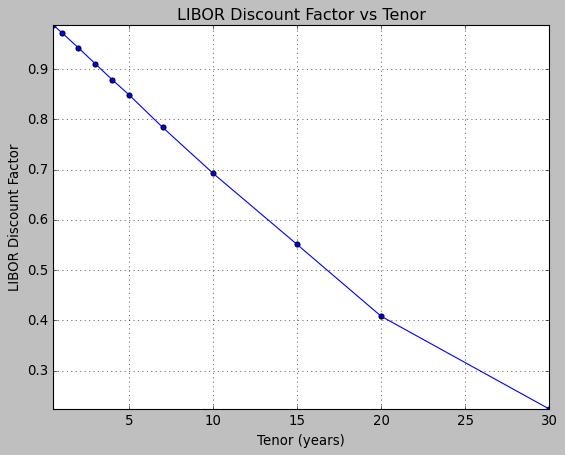

In [8]:
libor_bootstrapping = LIBORBootstrapping(file_directory, df_ois, 0.5, 0.5)

In [9]:
libor_bootstrapping.df_irs

,Product,Rate,Tenor Delta,Discount Factor,Forward LIBOR
Tenor,,,,,
0.5,LIBOR,0.0250,0.5,0.987654,0.025000
1.0,IRS,0.0280,0.5,0.972577,0.031005
2.0,IRS,0.0300,1.0,0.942179,0.032263
3.0,IRS,0.0315,1.0,0.910482,0.034814
4.0,IRS,0.0325,1.0,0.878981,0.035838
5.0,IRS,0.0330,1.0,0.848989,0.035326
7.0,IRS,0.0350,2.0,0.784216,0.041298
10.0,IRS,0.0370,3.0,0.692710,0.044033
15.0,IRS,0.0400,5.0,0.551081,0.051401
